In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score






In [2]:
mentalhealth_df = pd.read_csv('mental_health_data final data.csv')
mentalhealth_df.drop(columns=['User_ID', 'Country',])
mentalhealth_df['Severity'] = mentalhealth_df['Severity'].fillna('NA')
mentalhealth_df.head()

,User_ID,Age,Gender,Occupation,Country,Mental_Health_Condition,Severity,Consultation_History,Stress_Level,Sleep_Hours,Work_Hours,Physical_Activity_Hours,Social_Media_Usage,Diet_Quality,Smoking_Habit,Alcohol_Consumption,Medication_Usage
0,1,36,Male,Education,Australia,Yes,NA,Yes,Low,7.6,46,8,2.2,Healthy,Regular Smoker,Regular Drinker,Yes
1,2,48,Male,Engineering,Other,No,Low,No,Low,6.8,74,2,3.4,Unhealthy,Heavy Smoker,Social Drinker,No
2,3,18,Prefer not to say,Sales,India,No,NA,Yes,Medium,7.1,77,9,5.9,Healthy,Heavy Smoker,Social Drinker,No
3,4,30,Non-binary,Engineering,Australia,No,Medium,No,Low,6.9,57,4,5.4,Average,Regular Smoker,Regular Drinker,No
4,5,58,Male,IT,USA,Yes,NA,Yes,High,4.7,45,10,3.3,Unhealthy,Regular Smoker,Non-Drinker,Yes


In [3]:
mentalhealth_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   User_ID                  50000 non-null  int64  
 1   Age                      50000 non-null  int64  
 2   Gender                   50000 non-null  object 
 3   Occupation               50000 non-null  object 
 4   Country                  50000 non-null  object 
 5   Mental_Health_Condition  50000 non-null  object 
 6   Severity                 50000 non-null  object 
 7   Consultation_History     50000 non-null  object 
 8   Stress_Level             50000 non-null  object 
 9   Sleep_Hours              50000 non-null  float64
 10  Work_Hours               50000 non-null  int64  
 11  Physical_Activity_Hours  50000 non-null  int64  
 12  Social_Media_Usage       50000 non-null  float64
 13  Diet_Quality             50000 non-null  object 
 14  Smoking_Habit         

Below I have a first attempt section and another try, different ways of formulating the problem. You should only run one section; meaning if you are trying the 'first attempt', skip 'another try' and vice versa. Then pick up where you left off at Modeling.

# First Attempt - Prof Roth

The changes I made:
 - I made the target Severity. That's what I understood from May.
 - I included Age and Gender as features.
 - I fixed the columnTransformer (which I introduced broken). I was applying the columnTransformer only to the ordinal features, but you are supposed to pass in the entire feature set; it knows which columns to apply the ordinal transformer to.

 I manage to get around 50%, which for a 4-class classification is 2x better than chance.


In [4]:
# feature = mentalhealth_df.drop(columns=['User_ID','Gender', 'Age','Occupation', 'Country', 'Consultation_History', 'Stress_Level', 'Medication_Usage', 'Mental_Health_Condition'])
# target = mentalhealth_df[['Stress_Level']]  

feature = mentalhealth_df.drop(columns=['User_ID','Occupation', 'Country', 'Consultation_History', 'Medication_Usage', 'Mental_Health_Condition', 'Severity'])
target = mentalhealth_df[['Severity']]



In [5]:

ord_features = ['Diet_Quality', 'Smoking_Habit', 'Alcohol_Consumption', 'Stress_Level']
ord_order = [['Unhealthy', 'Average', 'Healthy'],
             ['Non-Smoker', 'Occasional Smoker', 'Regular Smoker', 'Heavy Smoker'],
             ['Non-Drinker', 'Social Drinker', 'Regular Drinker', 'Heavy Drinker'],
             ['Low', 'Medium', 'High']]

           
encoder = OrdinalEncoder(categories=ord_order)

cat_features = ['Gender']
oh_encoder = OneHotEncoder()

ct = ColumnTransformer([('encoder', encoder, ord_features), 
                        ('oh', oh_encoder, cat_features)], 
                       remainder='passthrough', 
                       verbose_feature_names_out=False)

encoded_data = ct.fit_transform(feature)

label_order = ['NA', 'Low', 'Medium', 'High']
label_encoder = OrdinalEncoder(categories=[label_order])
encoded_target = label_encoder.fit_transform(target)

print(encoded_data.shape)
print(encoded_target)

(50000, 13)
[[0.]
 [1.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]


## Another try

This time, I've made the problem binary. Severity of NA or Low are 0, and Medium and High are 1.

I get 66% accuracy. That's not better, because in a binary classification, random choice is 50%.

In [6]:
feature = mentalhealth_df.drop(columns=['User_ID','Occupation', 'Country', 'Consultation_History', 'Medication_Usage', 'Mental_Health_Condition', 'Severity'])

target = mentalhealth_df[['Severity']]
target['Severity'] = target['Severity'].map({'NA': 0, 'Low': 0, 'Medium': 1, 'High': 1})

C:\Users\sebal\AppData\Local\Temp\ipykernel_5308\1819701092.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target['Severity'] = target['Severity'].map({'NA': 0, 'Low': 0, 'Medium': 1, 'High': 1})


In [7]:

ord_features = ['Diet_Quality', 'Smoking_Habit', 'Alcohol_Consumption', 'Stress_Level']
ord_order = [['Unhealthy', 'Average', 'Healthy'],
             ['Non-Smoker', 'Occasional Smoker', 'Regular Smoker', 'Heavy Smoker'],
             ['Non-Drinker', 'Social Drinker', 'Regular Drinker', 'Heavy Drinker'],
             ['Low', 'Medium', 'High']]

           
encoder = OrdinalEncoder(categories=ord_order)

cat_features = ['Gender']
oh_encoder = OneHotEncoder()

ct = ColumnTransformer([('encoder', encoder, ord_features), 
                        ('oh', oh_encoder, cat_features)], 
                       remainder='passthrough', 
                       verbose_feature_names_out=False)

encoded_data = ct.fit_transform(feature)

encoded_target = target

print(encoded_data.shape)
print(encoded_target)

(50000, 13)
       Severity
0             0
1             0
2             0
3             1
4             0
...         ...
49995         1
49996         0
49997         0
49998         0
49999         0

[50000 rows x 1 columns]


# Modeling

In [8]:
X = encoded_data
y = encoded_target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dt_params = {'max_depth': [2, 5, 10],
            'min_samples_split': [100, 300, 1000, 3000]}

dt = DecisionTreeClassifier()
dt_grid = GridSearchCV(dt, dt_params, scoring='accuracy', cv=5)
dt_grid.fit(X_train, y_train)

rf = RandomForestClassifier(n_estimators=300)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print('Random Forest', accuracy_score(y_test, rf_pred))

model_best = dt_grid.best_estimator_
dt_pred = model_best.predict(X_test)
dt_pred_train = model_best.predict(X_train)
print('Decision Tree', accuracy_score(y_test, dt_pred))

c:\Users\sebal\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest 0.6564
Decision Tree 0.6632


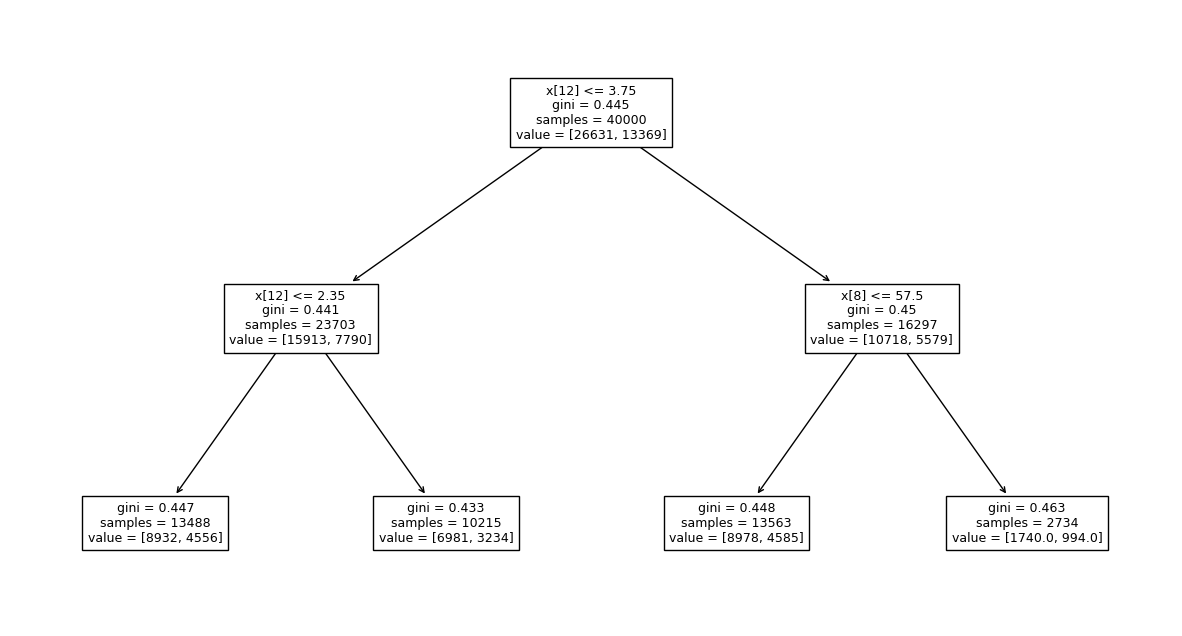

In [9]:
fig, ax = plt.subplots(1,1, figsize = (15, 8))
plot_tree(model_best, fontsize=9)
plt.show()

In [14]:
correct = (dt_pred.flatten() == y_test.values.flatten())
correct_pct = np.mean(1.0 * correct)
correct_pct

0.6632

Text(792.3131313131312, 0.5, 'Actual')

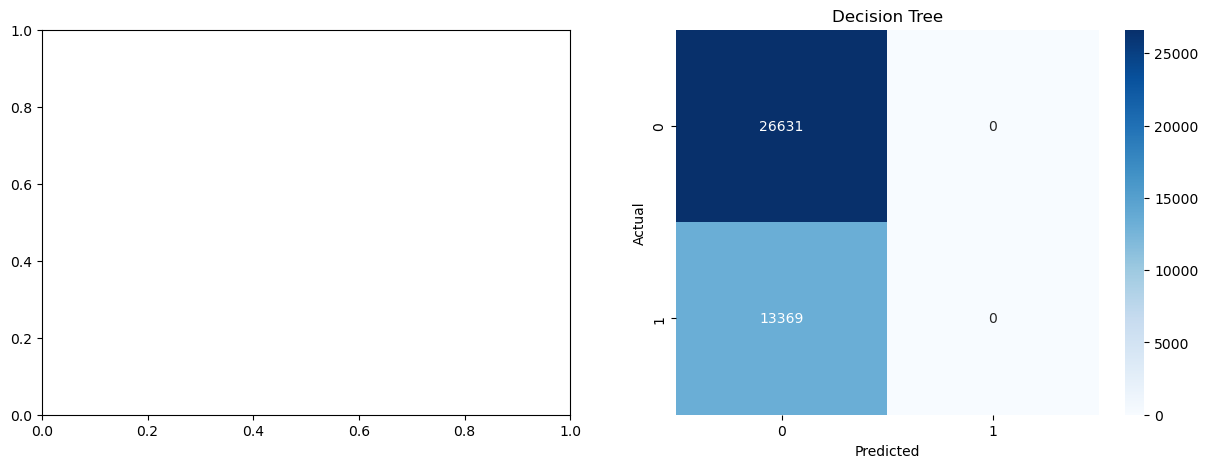

In [15]:
dt_cm = confusion_matrix(y_train, dt_pred_train)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(dt_cm, annot=True, fmt='d', ax=axes[1], cmap='Blues')
axes[1].set_title('Decision Tree')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

In [5]:
pip list

Package                           Version
--------------------------------- ------------------
absl-py                           2.2.2
aext-assistant                    4.1.0
aext-assistant-server             4.1.0
aext-core                         4.1.0
aext-core-server                  4.1.0
aext-panels                       4.1.0
aext-panels-server                4.1.0
aext-project-filebrowser-server   4.1.0
aext-share-notebook               4.1.0
aext-share-notebook-server        4.1.0
aext-shared                       4.1.0
aext-toolbox                      4.1.0
aiobotocore                       2.12.3
aiohttp                           3.9.5
aioitertools                      0.7.1
aiosignal                         1.2.0
alabaster                         0.7.16
alembic                           1.13.3
altair                            5.0.1
anaconda-anon-usage               0.4.4
anaconda-catalogs                 0.2.0
anaconda-cli-base                 0.4.1
anaconda-client       

In [6]:

pip install - upgrade tensorflow keras

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '-'


In [2]:
from keras.datasets import california_housing
from keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.preprocessing import StandardScaler



ImportError: Traceback (most recent call last):
  File "c:\Users\sebal\anaconda3\Lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic link library (DLL) initialization routine failed.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

In [24]:
# Build the neural network model
mlp = Sequential([
    Dense(8, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(4, activation = 'softmax')
])

# Compile the model
mlp.compile(optimizer='adam', loss='mse')

ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

# Train the model
mlp.fit(Xs_train, y_train, epochs=50, batch_size=128, validation_split=0.2, verbose=0)

# Predict values for training and test sets
y_mlp_train = np.argmax(mlp.predict(Xs_train), axis = 1)
y_mlp = np.argmax(mlp.predict(Xs_test), axis = 1)


NameError: name 'Sequential' is not defined

In [12]:
accuracy_score(y_mlp, y_test)

0.3318